In [1]:
import deepchem as dc

/home/alessandro/miniconda3/envs/deepchem/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
RDKit WARNING: [17:12:40] Enabling RDKit 2019.09.3 jupyter extensions
/home/alessandro/miniconda3/envs/deepchem/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alessandro/miniconda3/envs/deepchem/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passin

## load data

In [2]:
??dc.molnet.load_tox21

In [3]:
??dc.data.CSVLoader

In [4]:
??dc.utils.save.load_csv_files

In [7]:
!pwd

/home/alessandro/workshop/Learning/CompBio/Code/alchem/notebooks/Understanding


In [8]:
from pathlib import Path
import pandas as pd

datasets_dir = Path('../../datasets/')
tox21_dataset_file = datasets_dir/"tox21.csv.gz"
tox21 = pd.read_csv(tox21_dataset_file)

In [9]:
tox21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8014 entries, 0 to 8013
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NR-AR          7439 non-null   float64
 1   NR-AR-LBD      6902 non-null   float64
 2   NR-AhR         6691 non-null   float64
 3   NR-Aromatase   5940 non-null   float64
 4   NR-ER          6316 non-null   float64
 5   NR-ER-LBD      7112 non-null   float64
 6   NR-PPAR-gamma  6583 non-null   float64
 7   SR-ARE         5935 non-null   float64
 8   SR-ATAD5       7232 non-null   float64
 9   SR-HSE         6594 non-null   float64
 10  SR-MMP         5920 non-null   float64
 11  SR-p53         6909 non-null   float64
 12  mol_id         8014 non-null   object 
 13  smiles         8014 non-null   object 
dtypes: float64(12), object(2)
memory usage: 876.7+ KB


## featurise

In [10]:
?? dc.feat.graph_features.ConvMolFeaturizer

In [11]:
??dc.feat.graph_features.ConvMolFeaturizer._get_atom_properties

In [12]:
from rdkit import Chem
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
import numpy as np

In [13]:
sample_elems = tox21['smiles'].tolist()
sample_elems[:5]

['CCOc1ccc2nc(S(N)(=O)=O)sc2c1',
 'CCN1C(=O)NC(c2ccccc2)C1=O',
 'CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C',
 'CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C',
 'CC(O)(P(=O)(O)O)P(=O)(O)O']

### featurise one molecule step by step for understanding

In [14]:
mol = Chem.MolFromSmiles(sample_elems[0])
type(mol)

rdkit.Chem.rdchem.Mol

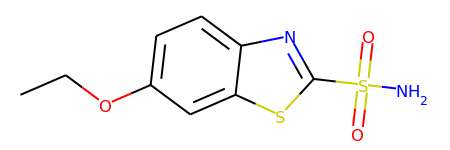

In [15]:
from rdkit.Chem.Draw import IPythonConsole 
mol

In [16]:
for atom in mol.GetAtoms():
    print(atom.GetSymbol())    

C
C
O
C
C
C
C
N
C
S
N
O
O
S
C
C


In [17]:
print(mol.GetBonds()[10].GetBondType())

DOUBLE


In [18]:
# reorder the atoms so that they're always in the same canonical order
new_order = rdmolfiles.CanonicalRankAtoms(mol)
mol = rdmolops.RenumberAtoms(mol, new_order)

In [19]:
def one_of_k_encoding(x, allowable_set):
  if x not in allowable_set:
    raise Exception("input {0} not in allowable set{1}:".format(
        x, allowable_set))
  return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
  """Maps inputs not in the allowable set to the last element."""
  if x not in allowable_set:
    x = allowable_set[-1]
  return list(map(lambda s: x == s, allowable_set))

def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
  """Helper method used to compute per-atom feature vectors.

  Many different featurization methods compute per-atom features such as ConvMolFeaturizer, WeaveFeaturizer. This method computes such features.

  Parameters
  ----------
  bool_id_feat: bool, optional
    Return an array of unique identifiers corresponding to atom type.
  explicit_H: bool, optional
    If true, model hydrogens explicitly
  use_chirality: bool, optional
    If true, use chirality information.
  """
  if bool_id_feat:
    return np.array([atom_to_id(atom)])
  else:
    from rdkit import Chem
    results = one_of_k_encoding_unk(
      atom.GetSymbol(),
      [
        'C',
        'N',
        'O',
        'S',
        'F',
        'Si',
        'P',
        'Cl',
        'Br',
        'Mg',
        'Na',
        'Ca',
        'Fe',
        'As',
        'Al',
        'I',
        'B',
        'V',
        'K',
        'Tl',
        'Yb',
        'Sb',
        'Sn',
        'Ag',
        'Pd',
        'Co',
        'Se',
        'Ti',
        'Zn',
        'H',  # H?
        'Li',
        'Ge',
        'Cu',
        'Au',
        'Ni',
        'Cd',
        'In',
        'Mn',
        'Zr',
        'Cr',
        'Pt',
        'Hg',
        'Pb',
        'Unknown'
      ]) + one_of_k_encoding(atom.GetDegree(),
                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
      results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
      try:
        results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
      except:
        results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)


In [20]:
def get_atom_properties(atom):
    """
    For a given input RDKit atom return the values of the properties
    requested when initializing the featurize.  See the __init__ of the
    class for a full description of the names of the properties

    Parameters
    ----------
    atom: RDKit.rdchem.Atom
      Atom to get the properties of
    returns a numpy lists of floats of the same size as self.atom_properties
    """
    values = []
    for prop in []:
      mol_prop_name = str("atom %08d %s" % (atom.GetIdx(), prop))
      try:
        values.append(float(atom.GetOwningMol().GetProp(mol_prop_name)))
      except KeyError:
        raise KeyError("No property %s found in %s in %s" %
                       (mol_prop_name, atom.GetOwningMol(), self))
    return np.array(values)

In [21]:
# Get the node features
idx_nodes = [(a.GetIdx(),
              np.concatenate((atom_features(
                  a, use_chirality=False),
                              get_atom_properties(a))))
             for a in mol.GetAtoms()]

idx_nodes.sort()  # Sort by ind to ensure same order as rd_kit
idx, nodes = list(zip(*idx_nodes))

In [22]:
len((atom_features(next(mol.GetAtoms()), use_chirality=False)))

75

In [23]:
get_atom_properties(next(mol.GetAtoms()))

array([], dtype=float64)

In [24]:
 next(mol.GetAtoms())

In [25]:
print(f'{len(idx)} atoms each with a '\
      f'feature set of dimensionality {(nodes[0].shape[0])}')

16 atoms each with a feature set of dimensionality 75


In [26]:
# Stack nodes into an array
nodes = np.vstack(nodes)

In [27]:
nodes.shape

(16, 75)

In [28]:
# Get bond lists with reverse edges included
edge_list = [
    (b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds()
]


In [29]:
edge_list

[(0, 10),
 (10, 11),
 (11, 12),
 (12, 4),
 (4, 5),
 (5, 15),
 (15, 1),
 (1, 7),
 (7, 2),
 (2, 13),
 (2, 3),
 (2, 8),
 (7, 6),
 (6, 14),
 (14, 9),
 (9, 12),
 (14, 15)]

In [30]:
# Get canonical adjacency list
canon_adj_list = [[] for mol_id in range(len(nodes))]
for edge in edge_list:
  canon_adj_list[edge[0]].append(edge[1])
  canon_adj_list[edge[1]].append(edge[0])

In [31]:
canon_adj_list

[[10],
 [15, 7],
 [7, 13, 3, 8],
 [2],
 [12, 5],
 [4, 15],
 [7, 14],
 [1, 2, 6],
 [2],
 [14, 12],
 [0, 11],
 [10, 12],
 [11, 4, 9],
 [2],
 [6, 9, 15],
 [5, 1, 14]]

### Convert  atom features and adjacency list into ConvMol object

#####  ConvMol:

Holds degree information

Resorts order of atoms internally to be in order of increasing degree(hydrogens excluded). 



In [32]:
conv_mol = dc.feat.mol_graphs.ConvMol(nodes, canon_adj_list)

In [33]:
??dc.feat.mol_graphs.ConvMol

In [34]:
def my_dir(obj):
    return [x for x in dir(obj) if not x.startswith('__')]

my_dir(conv_mol)

['_deg_sort',
 'agglomerate_mols',
 'atom_features',
 'canon_adj_list',
 'deg_adj_lists',
 'deg_block_indices',
 'deg_id_list',
 'deg_list',
 'deg_slice',
 'deg_start',
 'degree_list',
 'get_adjacency_list',
 'get_atom_features',
 'get_atoms_with_deg',
 'get_deg_adjacency_lists',
 'get_deg_slice',
 'get_null_mol',
 'get_num_atoms',
 'get_num_atoms_with_deg',
 'max_deg',
 'membership',
 'min_deg',
 'n_atoms',
 'n_feat']

## Repeat for all molecules

In [35]:
def get_features_adj_list(mol):
    # Get the node features
    idx_nodes = [(a.GetIdx(),
              np.concatenate((atom_features(
                  a, use_chirality=False),
                              get_atom_properties(a))))
             for a in mol.GetAtoms()]

    idx_nodes.sort()  # Sort by ind to ensure same order as rd_kit
    idx, nodes = list(zip(*idx_nodes))
    
    # Stack nodes into an array
    nodes = np.vstack(nodes)
    
    # Get bond lists with reverse edges included
    edge_list = [
        (b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds()
    ]

    # Get canonical adjacency list
    canon_adj_list = [[] for mol_id in range(len(nodes))]
    for edge in edge_list:
      canon_adj_list[edge[0]].append(edge[1])
      canon_adj_list[edge[1]].append(edge[0])

    

    return nodes, canon_adj_list


In [36]:
features = []
for ind, elem in enumerate(sample_elems):
    mol = Chem.MolFromSmiles(elem)
    # TODO (ytz) this is a bandage solution to reorder the atoms so
    # that they're always in the same canonical order. Presumably this
    # should be correctly implemented in the future for graph mols.
    if mol:
      new_order = rdmolfiles.CanonicalRankAtoms(mol)
      mol = rdmolops.RenumberAtoms(mol, new_order)
    if ind % 100 == 0:
      print("Featurizing sample %d" % ind)
    nodes, adj_list = get_features_adj_list(mol)
    features.append(dc.feat.mol_graphs.ConvMol(nodes, adj_list))

Featurizing sample 0
Featurizing sample 100
Featurizing sample 200


RDKit WARNING: [19:01:23] WARNING: not removing hydrogen atom without neighbors


Featurizing sample 300
Featurizing sample 400
Featurizing sample 500
Featurizing sample 600
Featurizing sample 700
Featurizing sample 800
Featurizing sample 900
Featurizing sample 1000
Featurizing sample 1100
Featurizing sample 1200
Featurizing sample 1300
Featurizing sample 1400
Featurizing sample 1500
Featurizing sample 1600
Featurizing sample 1700
Featurizing sample 1800
Featurizing sample 1900
Featurizing sample 2000
Featurizing sample 2100
Featurizing sample 2200
Featurizing sample 2300
Featurizing sample 2400
Featurizing sample 2500
Featurizing sample 2600
Featurizing sample 2700
Featurizing sample 2800
Featurizing sample 2900
Featurizing sample 3000
Featurizing sample 3100
Featurizing sample 3200
Featurizing sample 3300
Featurizing sample 3400
Featurizing sample 3500
Featurizing sample 3600
Featurizing sample 3700
Featurizing sample 3800
Featurizing sample 3900
Featurizing sample 4000
Featurizing sample 4100
Featurizing sample 4200
Featurizing sample 4300
Featurizing sample 4400

In [61]:
len(features) == len(sample_elems)

True

In [62]:
type(features[0])

deepchem.feat.mol_graphs.ConvMol

### Back to using prebuilts

In [64]:
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv', reload=False)
train_dataset, valid_dataset, test_dataset = tox21_datasets

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0


RDKit WARNING: [09:40:37] WARNING: not removing hydrogen atom without neighbors


Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 8.122 s
TIMING: dataset construction took 9.888 s
Loading dataset from disk.
TIMING: dataset construction took 1.910 s
Loading dataset from disk.
TIMING: dataset construction took 0.822 s
Loading dataset from disk.
TIMING: dataset construction took 0.943 s
Loading dataset from disk.
TIMING: dataset construction took 1.840 s
Loading dataset from disk.
TIMING: dataset construction took 0.201 s
Loading dataset from disk.
TIMING: dataset construction took 0.208 s
Loading dataset from disk.


In [65]:
type(train_dataset.X[0])

deepchem.feat.mol_graphs.ConvMol

In [69]:
train_dataset.X[0].atom_features.shape

(16, 75)


# Model & Training

In [72]:
from deepchem.models.graph_models import GraphConvModel

In [73]:
??GraphConvModel.__init__

![title](GCN.png)

In [74]:
from deepchem.models.layers import GraphConv

In [75]:
??GraphConv

### key inputs

- deg_adj
- membership
- degree slice
